In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *
from torchvision import transforms

In [5]:
import zipfile
with zipfile.ZipFile('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/CAMPUS/jamb2018/arcs-j/Images')

In [3]:
path = Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack')

In [4]:
path.ls()

(#14322) [Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/10265_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/07391_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/09797_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/03802_right.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/03927_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/08781_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/00627_right.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/12836_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/08602_straight.png'),Path('/home/CAMPUS/jamb2018/arcs-j/Images/AutoStack/12759_right.png')...]

# Stacking images vertically

In [5]:
def get_pair(o):
    curr_im_num = Path(o).name[:5]
    if not int(curr_im_num):
        prev_im_num = curr_im_num
    else:
        prev_im_num = int(curr_im_num)-1
    
    prev_im = None
    for item in Path(o).parent.ls():
        if int(item.name[:5]) == prev_im_num:
            prev_im = item
    if prev_im is None:
        prev_im = Path(o)
        
    assert prev_im != None
    
    img1 = Image.open(o).convert('RGB')
    img2 = Image.open(prev_im).convert('RGB')
    img1_t = transforms.ToTensor()(img1).unsqueeze_(0)
    img2_t = transforms.ToTensor()(img2).unsqueeze_(0)
    
    new_shape = list(img1_t.shape)
    new_shape[-2] = new_shape[-2] * 2
    img3_t = torch.zeros(new_shape)

    img3_t[:, :, :240, :] = img1_t
    img3_t[:, :, 240:, :] = img2_t
    
    img3 = transforms.ToPILImage()(img3_t.squeeze_(0))
    
    return np.array(img3)

In [40]:
get_pair(path/'00001_straight.png').shape

(480, 320, 3)

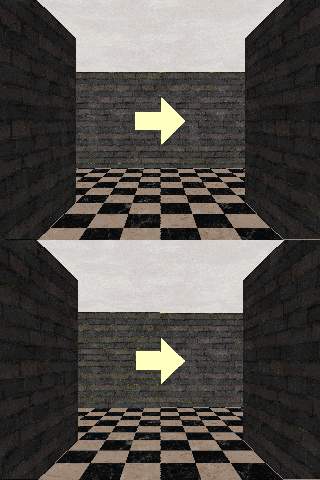

In [39]:
Image.fromarray(get_pair(path/'00001_straight.png'))

## Classification 1

In [7]:
db = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_x=get_pair,
        get_y=lambda x: x.name[6:-4],
        splitter=RandomSplitter(valid_pct=0.2, seed=47)
)

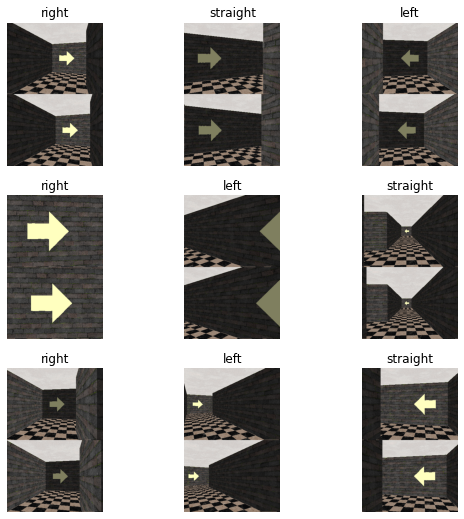

In [8]:
dls = db.dataloaders(path, bs=64)
dls.show_batch()

In [9]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(50, cbs=[SaveModelCallback(), 
                           EarlyStoppingCallback(monitor='valid_loss',
                                                 patience=10)])

epoch,train_loss,valid_loss,error_rate,time
0,0.567924,0.400276,0.107891,01:23


Better model found at epoch 0 with valid_loss value: 0.4002756178379059.


epoch,train_loss,valid_loss,error_rate,time
0,0.342080,0.278404,0.086592,01:23
1,0.237463,0.238314,0.077863,01:24
2,0.151216,0.278527,0.084846,01:24
3,0.117635,0.296719,0.080656,01:23
4,0.116794,0.315048,0.073324,01:23
5,0.094631,0.315451,0.072626,01:24
6,0.119501,0.357144,0.082053,01:24
7,0.089641,0.361563,0.077863,01:24
8,0.119884,0.304101,0.080307,01:24
9,0.082282,0.297626,0.065992,01:24


Better model found at epoch 0 with valid_loss value: 0.2784038186073303.
Better model found at epoch 1 with valid_loss value: 0.23831366002559662.
No improvement since epoch 1: early stopping


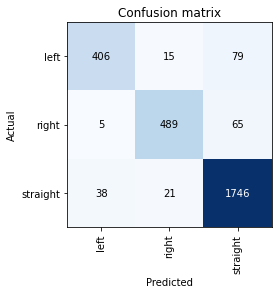

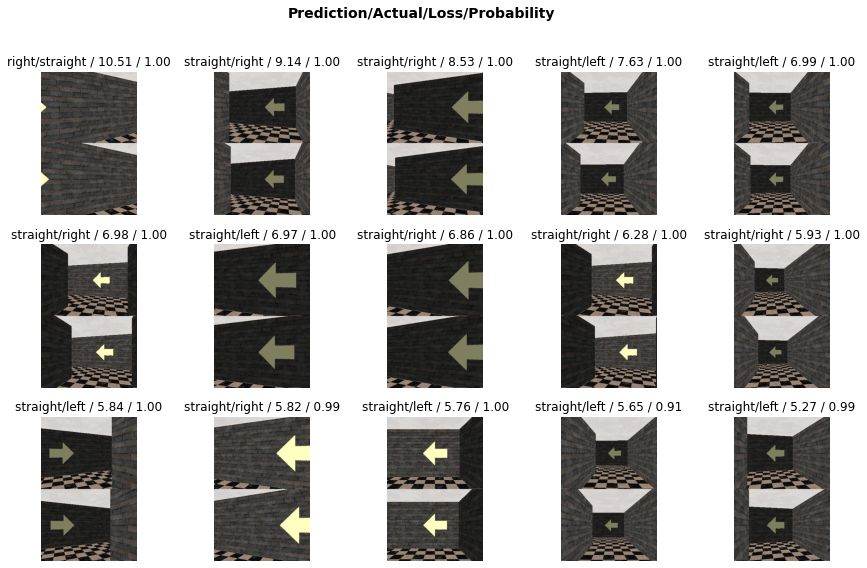

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15)

In [62]:
learn.export('/home/CAMPUS/jamb2018/arcs-j/Models/auto-stack-c1.pkl')

PicklingError: Can't pickle <function <lambda> at 0x7f2578577ee0>: attribute lookup <lambda> on __main__ failed

## Regression 1

In [11]:
def name_to_deg(f):
    label = f.name[6:-4]
    if label == 'left': return 90.
    elif label == 'right': return -90.
    else: return 0.

In [12]:
def sin_cos_loss(preds, targs):
    rad_targs = targs / 180 * np.pi
    x_targs = torch.cos(rad_targs)
    y_targs = torch.sin(rad_targs)
    x_preds = preds[:, 0]
    y_preds = preds[:, 1]
    return ((x_preds - x_targs)**2 + (y_preds - y_targs)**2).mean()

In [13]:
def within_angle(preds, targs, angle):
    rad_targs = targs / 180 * np.pi
    angle_pred = torch.atan2(preds[:,1], preds[:,0])
    abs_diff = torch.abs(rad_targs - angle_pred)
    angle_diff = torch.where(abs_diff > np.pi, np.pi*2. - abs_diff, abs_diff)
    return torch.where(angle_diff < angle, 1., 0.).mean()

In [14]:
def within_45_deg(preds, targs):
    return within_angle(preds, targs, np.pi / 4)

In [15]:
def within_30_deg(preds, targs):
    return within_angle(preds, targs, np.pi / 6)

In [16]:
def within_15_deg(preds, targs):
    return within_angle(preds, targs, np.pi / 12)

In [17]:
db_r = DataBlock(
        blocks=(ImageBlock, RegressionBlock(n_out=2)),
        get_items=get_image_files,
        get_x=get_pair,
        get_y=name_to_deg,
        splitter=RandomSplitter(valid_pct=0.2, seed=47)
)

dls_r = db_r.dataloaders(path, bs=128)

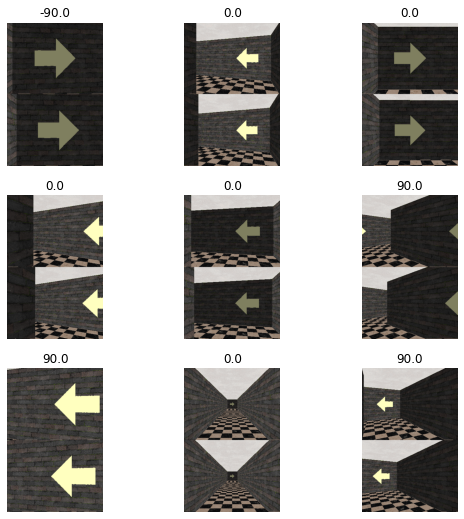

In [18]:
dls_r.show_batch()

In [19]:
learn_r = cnn_learner(dls_r, resnet34, loss_func=sin_cos_loss, y_range=(-1, 1),
                     metrics=[within_45_deg, within_30_deg, within_15_deg])
learn_r.fine_tune(50, cbs=[SaveModelCallback(), 
                           EarlyStoppingCallback(monitor='valid_loss',
                                                 patience=10)])

epoch,train_loss,valid_loss,within_45_deg,within_30_deg,within_15_deg,time
0,0.852450,0.511312,0.714385,0.522346,0.258729,01:40


Better model found at epoch 0 with valid_loss value: 0.511311948299408.


epoch,train_loss,valid_loss,within_45_deg,within_30_deg,within_15_deg,time
0,0.498311,0.384110,0.790154,0.649791,0.446229,01:42
1,0.413249,0.303430,0.887919,0.715782,0.572975,01:42
2,0.331014,0.243624,0.900838,0.791201,0.630936,01:42
3,0.267293,0.183008,0.908170,0.861383,0.717528,01:42
4,0.198734,0.150684,0.925628,0.883031,0.788408,01:42
5,0.159555,0.149889,0.931215,0.872207,0.811453,01:41
6,0.131975,0.131137,0.930866,0.895601,0.844972,01:42
7,0.110285,0.134022,0.926676,0.897346,0.857542,01:42
8,0.097336,0.130242,0.931913,0.905726,0.865922,01:42
9,0.084648,0.122458,0.928073,0.916201,0.884777,01:42


Better model found at epoch 0 with valid_loss value: 0.38410961627960205.
Better model found at epoch 1 with valid_loss value: 0.3034295439720154.
Better model found at epoch 2 with valid_loss value: 0.24362404644489288.
Better model found at epoch 3 with valid_loss value: 0.1830083727836609.
Better model found at epoch 4 with valid_loss value: 0.15068353712558746.
Better model found at epoch 5 with valid_loss value: 0.14988940954208374.
Better model found at epoch 6 with valid_loss value: 0.1311366707086563.
Better model found at epoch 8 with valid_loss value: 0.1302422285079956.
Better model found at epoch 9 with valid_loss value: 0.12245799601078033.
Better model found at epoch 14 with valid_loss value: 0.12144722789525986.
Better model found at epoch 16 with valid_loss value: 0.11356407403945923.
Better model found at epoch 20 with valid_loss value: 0.11138150095939636.
Better model found at epoch 29 with valid_loss value: 0.11110734194517136.
No improvement since epoch 29: early s

# Stacking Images by Depth

In [20]:
def get_first(o):
    img1 = Image.open(o)
    return np.array(img1)

In [21]:
def get_second(o):
    curr_im_num = Path(o).name[:5]
    if not int(curr_im_num):
        prev_im_num = curr_im_num
    else:
        prev_im_num = int(curr_im_num)-1
    
    prev_im = None
    for item in Path(o).parent.ls():
        if int(item.name[:5]) == prev_im_num:
            prev_im = item
    assert prev_im != None
    
#     img1 = Image.open(o).convert('RGB')
    img2 = Image.open(prev_im).convert('RGB')
#     img1_arr = np.array(img1)
    return np.array(img2)

In [41]:
def get_pair_2(o):
    curr_im_num = Path(o).name[:5]
    if not int(curr_im_num):
        prev_im_num = curr_im_num
    else:
        prev_im_num = int(curr_im_num)-1
    
    prev_im = None
    for item in Path(o).parent.ls():
        if int(item.name[:5]) == prev_im_num:
            prev_im = item
    if prev_im is None:
        prev_im = Path(o)
    assert prev_im != None
    
    img1 = Image.open(o).convert('RGB')
    img2 = Image.open(prev_im).convert('RGB')
    img1_arr = np.array(img1, dtype=np.uint8)
    img2_arr = np.array(img2, dtype=np.uint8)
        
    new_shape = list(img1_arr.shape)
    new_shape[-1] = new_shape[-1] * 2
    img3_arr = np.zeros(new_shape, dtype=np.uint8)

    img3_arr[:, :, :3] = img1_arr
    img3_arr[:, :, 3:] = img2_arr
    
    return img3_arr.T.astype(np.float32)

In [42]:
test_out = get_pair_2(path/'00001_straight.png')
test_out.shape

(6, 320, 240)

## Classification 2

In [26]:
db_2 = DataBlock(
        blocks=((ImageBlock, ImageBlock), CategoryBlock),
        get_items=get_image_files,
        get_x=get_pair_2,
        get_y=lambda x: x.name[6:-4],
        splitter=RandomSplitter(valid_pct=0.2, seed=47)
)
dls_2 = db_2.dataloaders(path, bs=64)

In [27]:
learn_2 = cnn_learner(dls_2, resnet34, metrics=error_rate)

In [28]:
learn_2.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [29]:
learn_2.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

In [30]:
learn_2.model

Sequential(
  (0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [31]:
learn_2.fine_tune(50, cbs=[SaveModelCallback(), 
                           EarlyStoppingCallback(monitor='valid_loss',
                                                 patience=10)])

epoch,train_loss,valid_loss,error_rate,time
0,0.408211,0.261811,0.062849,01:31


Better model found at epoch 0 with valid_loss value: 0.2618110179901123.


epoch,train_loss,valid_loss,error_rate,time
0,0.249273,0.203455,0.062849,01:31
1,0.162267,0.216007,0.061103,01:31
2,0.129700,0.255146,0.065293,01:31
3,0.101905,0.271480,0.056913,01:32
4,0.093986,0.308038,0.063547,01:32
5,0.093672,0.323195,0.067039,01:31
6,0.081937,0.403859,0.084497,01:31
7,0.074920,0.333030,0.061453,01:31
8,0.092764,0.257424,0.063198,01:31
9,0.078115,0.331360,0.060405,01:32


Better model found at epoch 0 with valid_loss value: 0.20345480740070343.
No improvement since epoch 0: early stopping


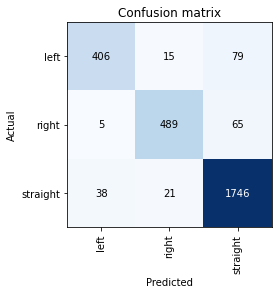

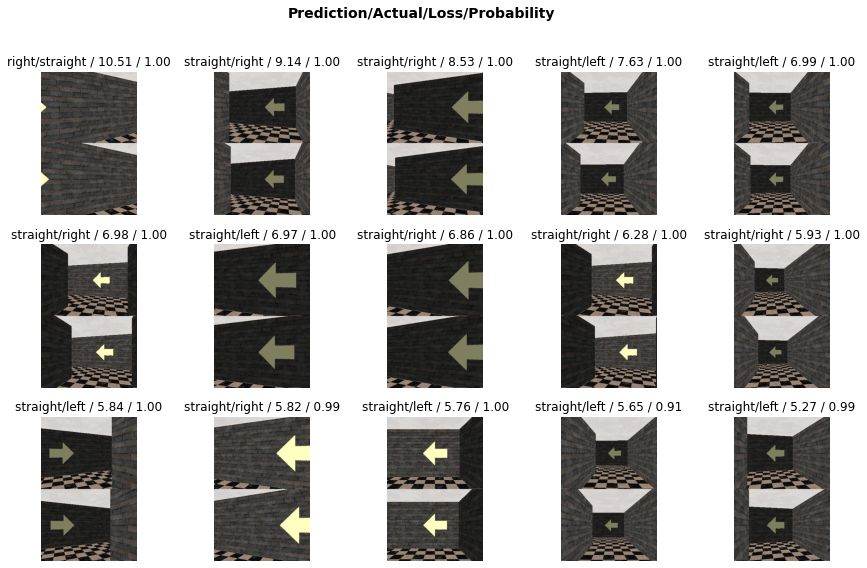

In [32]:
interp_2 = ClassificationInterpretation.from_learner(learn_2)
interp.plot_confusion_matrix()
interp.plot_top_losses(15)

## Regression 2

In [53]:
def get_pair_2_int(o):
    curr_im_num = Path(o).name[:5]
    if not int(curr_im_num):
        prev_im_num = curr_im_num
    else:
        prev_im_num = int(curr_im_num)-1
    
    prev_im = None
    for item in Path(o).parent.ls():
        if int(item.name[:5]) == prev_im_num:
            prev_im = item
    if prev_im is None:
        prev_im = Path(o)
    assert prev_im != None
    
    img1 = Image.open(o).convert('RGB')
    img2 = Image.open(prev_im).convert('RGB')
    img1_arr = np.array(img1, dtype=np.uint8)
    img2_arr = np.array(img2, dtype=np.uint8)
        
    new_shape = list(img1_arr.shape)
    new_shape[-1] = new_shape[-1] * 2
    img3_arr = np.zeros(new_shape, dtype=np.uint8)

    img3_arr[:, :, :3] = img1_arr
    img3_arr[:, :, 3:] = img2_arr
    
    return img3_arr

In [54]:
test_out = get_pair_2_int(path/'00001_straight.png')
test_out.shape

(240, 320, 6)

In [57]:
db_r_2 = DataBlock(
        blocks=((ImageBlock, ImageBlock), RegressionBlock(n_out=2)),
        get_items=get_image_files,
        get_x=get_pair_2,
        get_y=name_to_deg,
        splitter=RandomSplitter(valid_pct=0.2, seed=47)
)
dls_r_2 = db_r_2.dataloaders(path, bs=128)

In [59]:
learn_r_2 = cnn_learner(dls_r_2, resnet34, loss_func=sin_cos_loss, y_range=(-1, 1),
                     metrics=[within_45_deg, within_30_deg, within_15_deg])


In [60]:
learn_r_2.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

In [61]:
learn_r_2.fine_tune(50, cbs=[SaveModelCallback(monitor='valid_loss'), 
                            EarlyStoppingCallback(monitor='valid_loss',
                                                 patience=10)])

epoch,train_loss,valid_loss,within_45_deg,within_30_deg,within_15_deg,time
0,0.732854,0.436951,0.740922,0.595670,0.364176,01:41


Better model found at epoch 0 with valid_loss value: 0.43695124983787537.


epoch,train_loss,valid_loss,within_45_deg,within_30_deg,within_15_deg,time
0,0.401289,0.268197,0.849511,0.760475,0.612081,01:42
1,0.297010,0.191279,0.892807,0.834846,0.721718,01:42
2,0.227344,0.151403,0.913757,0.882682,0.810056,01:43
3,0.182165,0.138339,0.935754,0.890014,0.834497,01:42
4,0.162455,0.139408,0.914455,0.885475,0.835894,01:42
5,0.134503,0.118679,0.931215,0.911313,0.870461,01:42
6,0.114565,0.117098,0.929469,0.910964,0.877793,01:42
7,0.104065,0.119550,0.934008,0.899441,0.850908,01:42
8,0.090311,0.112146,0.932263,0.914804,0.886872,01:42
9,0.074739,0.117202,0.940642,0.914106,0.885824,01:43


Better model found at epoch 0 with valid_loss value: 0.26819708943367004.
Better model found at epoch 1 with valid_loss value: 0.19127914309501648.
Better model found at epoch 2 with valid_loss value: 0.15140336751937866.
Better model found at epoch 3 with valid_loss value: 0.13833941519260406.
Better model found at epoch 5 with valid_loss value: 0.11867870390415192.
Better model found at epoch 6 with valid_loss value: 0.11709819734096527.
Better model found at epoch 8 with valid_loss value: 0.11214598268270493.
Better model found at epoch 17 with valid_loss value: 0.11068204790353775.
Better model found at epoch 18 with valid_loss value: 0.10925346612930298.
Better model found at epoch 24 with valid_loss value: 0.10540524125099182.
Better model found at epoch 29 with valid_loss value: 0.10487435013055801.
No improvement since epoch 29: early stopping


In [63]:
learn_r_2.export('/home/CAMPUS/jamb2018/arcs-j/Models/auto-stack-r.pkl')